In [1]:

!pip install keras_tuner --upgrade

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import keras_tuner as kt

#models
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB5, Xception, MobileNetV3Large, ConvNeXtBase 

#preproces
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
SIZE = 260
bs = 8

### Visualisation

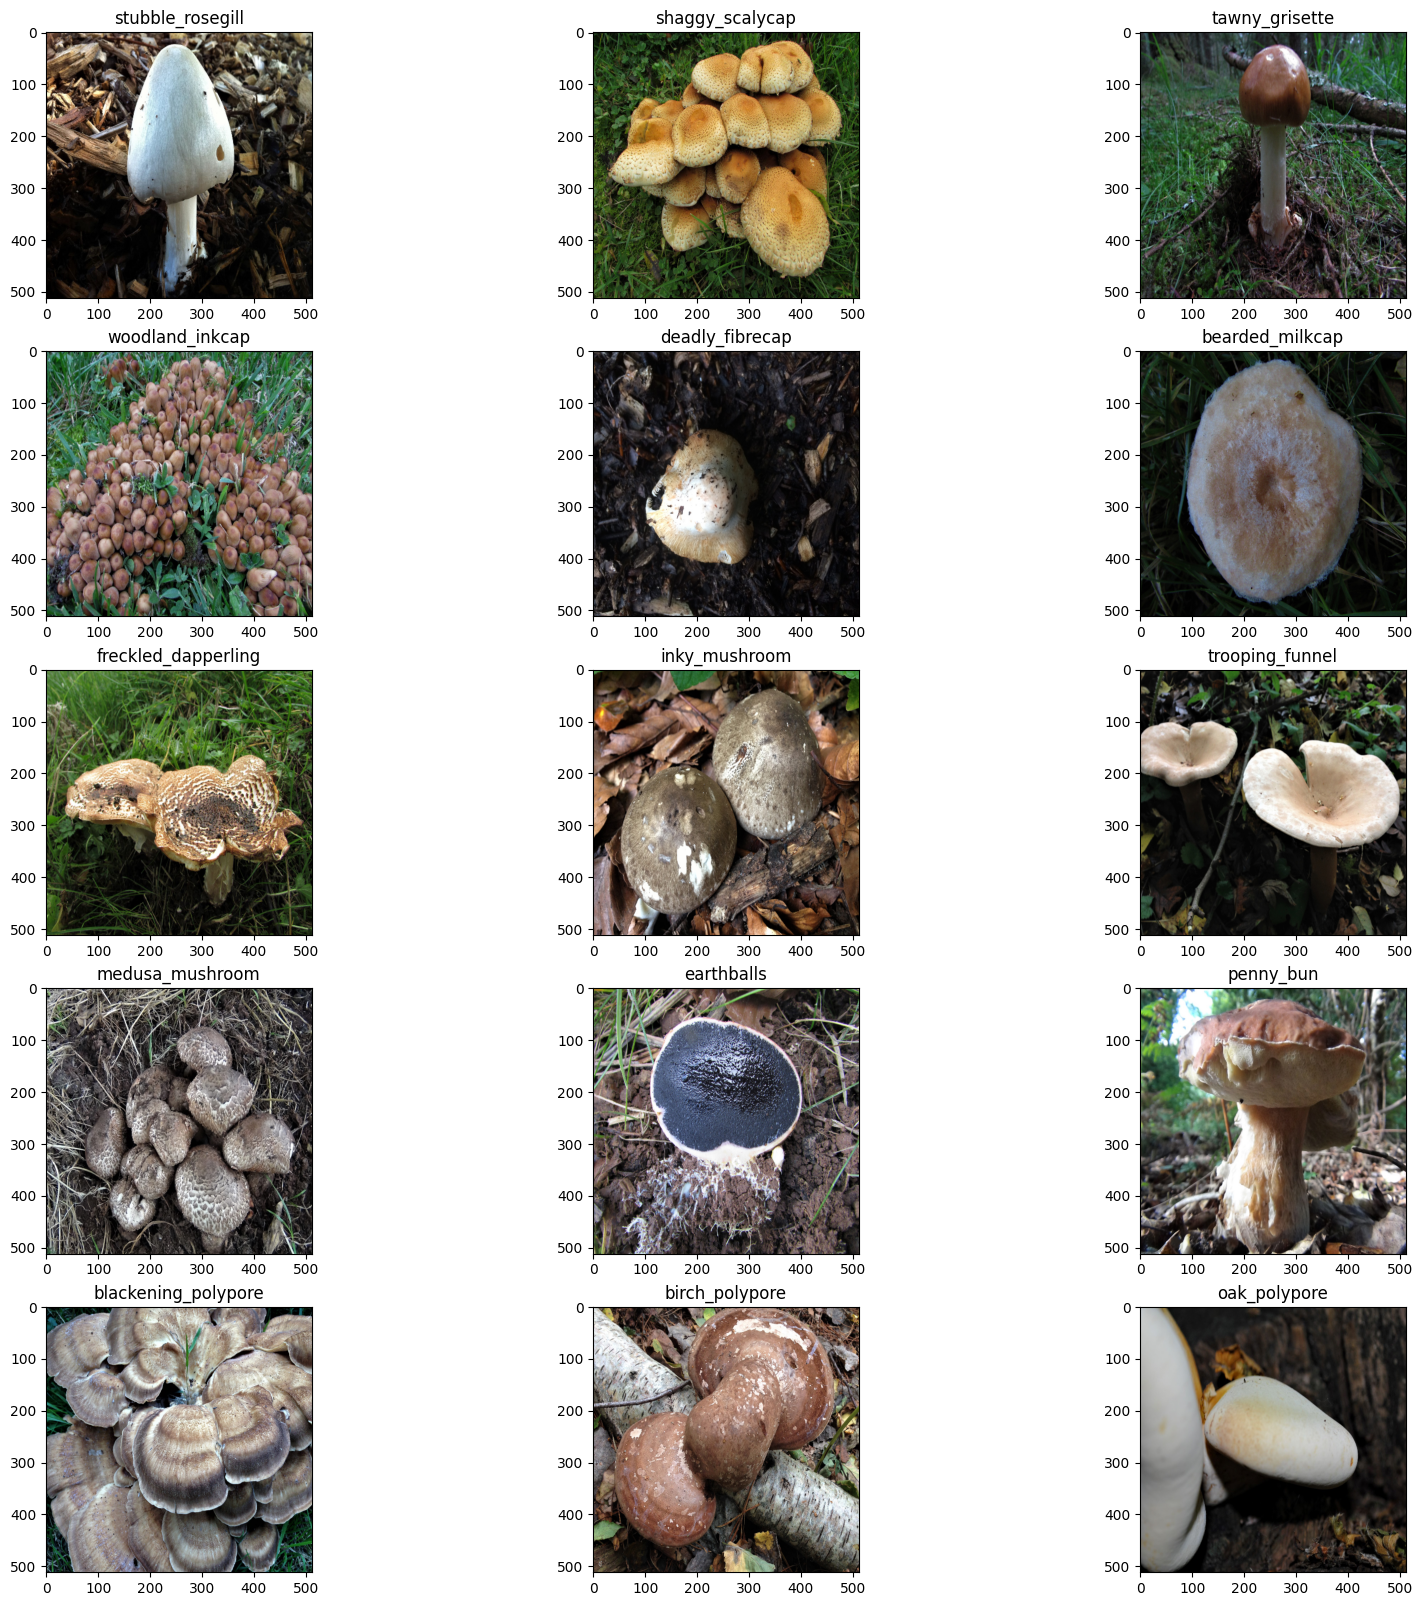

In [7]:

imgs = glob(r'/kaggle/input/mushrooms-classification/train/*/*')
fig , ax = plt.subplots(5, 3, figsize=(20, 20))
fig.subplots_adjust()
im_list = np.random.choice(imgs, 15)
for axi, im in zip( ax.flat, im_list):
    axi.set_title(im.split('/')[5],)
    axi.imshow(plt.imread(im), )

## Labels distribution

In [8]:

labels = [el.split('/')[5] for el in imgs ]
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 

In [9]:
unq = []
[unq.append(el) for el in distribution_dict.values() if el not in unq];
unq

[0.48, 0.4, 0.44, 0.36, 0.24, 0.32, 0.28, 0.52]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


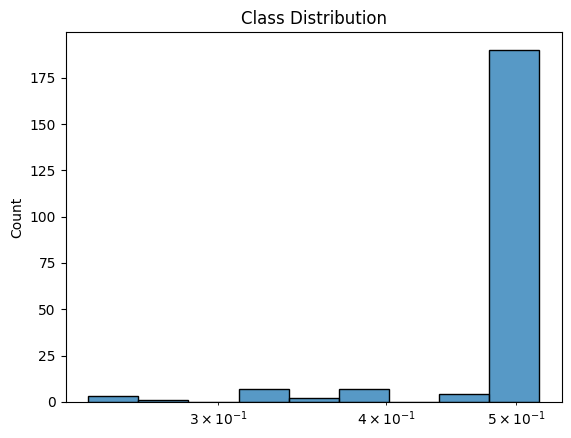

In [10]:
plt.title('Class Distribution')

sns.histplot(x=distribution_dict.values(),log_scale=True);

## Low frequency class

In [11]:

for k, v in distribution_dict.items():
        if v in [el for el in unq if el < 0.4]:
            print(k)

blushing_rosette
birch_woodwart
orange_birch_bolete
smoky_bracket
oak_polypore
golden_bootleg
deadly_webcap
devils_bolete
cinnamon_bracket
leccinum_albostipitatum
cedarwood_waxcap
hoof_fungus
rooting_shank


In [13]:
cls_weight = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

## Test train split 30 % for tuning

In [21]:

X_test =  glob(r'/kaggle/input/mushrooms-classification/test/*/*')

y_test  = [el.split('/')[5] for el in X_test ]

X_train =  glob(r'/kaggle/input/mushrooms-classification/train/*/*')
y_train = [el.split('/')[5] for el in X_train]

X_train,_, y_train, _ = train_test_split(X_train, y_train, test_size=0.7, stratify=y_train, random_state=96 )
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])


## Data generation

In [22]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        brightness_range=(1.0, 0.8),)
valid_gen = ImageDataGenerator(rescale=1./255)

train = datagen.flow_from_directory("/kaggle/input/mushrooms-classification/train")

In [23]:

tarin_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE))

Found 1247 validated image filenames belonging to 214 classes.
Found 624 validated image filenames belonging to 214 classes.


## Tuning

## TUNER MODEL TUNER

In [24]:



def build_model(hp, num_classes=214, shape=(SIZE,SIZE,3)):
    inputs = tf.keras.layers.Input(shape=shape)
    

    efb1 = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None)
    
    xcep = Xception(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)
    
    efb5 = EfficientNetB5(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)
    
    mnv3 = MobileNetV3Large(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)

    convnb = ConvNeXtBase(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)


    # EfficientNetB1, EfficientNetB5, Xception, MobileNetV3Large, ConvNeXtBase
    
    
    hp_model = hp.Choice('model', values=['efb1', 'xcep', 'efb5','mnv3', 'convnb'])
    
    if hp_model == 'efb1':
        model = efb1
    elif hp_model == 'xcep':
        model = xcep
    elif hp_model == 'efb5':
        model = efb5       
    elif hp_model == 'mnv3':
        model = mnv3
    elif hp_model == 'convnb':
        model = convnb
    else:
        raise
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    
    dropout_rate = 0.6
    x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs)
    
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=0.25,
        gamma=2.0,
        from_logits=False)
    
    learning_rate = 1e-2
    
 
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [27]:
t
= kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5, seed=123, metrics='ac'   




Reloading Tuner from ./untitled_project/tuner0.json


In [31]:

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3, seed=123)

Reloading Tuner from ./untitled_project/tuner0.json


In [32]:

tuner.search(tarin_gen, epochs=10, validation_data=test_gen, batch_size=bs)
#

Trial 5 Complete [00h 30m 02s]
val_loss: 1.4239623546600342

Best val_loss So Far: 1.3181662559509277
Total elapsed time: 07h 52m 46s


In [ ]:

tuner.results_summary()

In [ ]:

best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

## Optimize params

In [66]:
 def build_model(hp, num_classes=215, shape=(SIZE,SIZE,3)):
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB0(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        #classes=num_classes,
        classifier_activation='softmax')
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    
    hp_top_dropout_rate = hp.Choice('top_dropout_rate', values=[1e-2, 1e-3, 1e-4])
    x = tf.keras.layers.Dropout( hp_top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=0.25,
        gamma=2.0,
        from_logits=False)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop','nadam'])
    if hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=hp_learning_rate)
    else:
        raise
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model